In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

In [3]:
from uuid import uuid4

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = f"AIE7 - Certification Challenge - {uuid4().hex[0:8]}"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key: ")

In [4]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)

/tmp/ipykernel_84610/1911882425.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [5]:
from langchain_community.document_loaders import DirectoryLoader
from langchain_community.document_loaders import TextLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.txt", loader_cls=TextLoader, recursive=True)
historical_docs = loader.load()

In [6]:
len(historical_docs)

66

In [7]:
historical_docs[65]

Document(metadata={'source': 'data/newspaper_articles_1918/1918-03-07, 1, Tuckerton Beacon, new site selected.txt'}, page_content='```markdown PEOPLE ARISE TO DISCOVER EVIDENCES OF GOVERNMENT’S WAR ACTIVITIES \n\n**GREAT TRACT TAKEN OVER** *Elwood Stores and Homes Under Lease and Residents Prepare To Leave.*\n\nAtlantic City, March 3.—Transformed over-night from a peaceful Atlantic County hamlet into the nucleus of a great $11,000,000 shell-loading plant, Elwood, 25 miles from the resort, has been figuratively rubbing its eyes all day. When Elwoodians retired to rest last night they were surrounded by the quiet and calm that have characterized their community since the coming of the first settler.\n\nWhen they awoke today a large force of strangers had landed in their midst; their eyes beheld on the little-used side-track of the West Jersey & Seashore Railroad a half hundred freight cars bearing the legend, “Ordnance Department, U. S. A.,” and heavy motor trucks similarly decorated, ch

In [8]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 550, chunk_overlap = 50)
split_documents = text_splitter.split_documents(historical_docs)
len(split_documents)

388

In [9]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

In [10]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

client = QdrantClient(':memory:')

client.create_collection(
    collection_name='amatol_data',
    vectors_config=VectorParams(size=1536, distance=Distance.COSINE),
)

vector_store = QdrantVectorStore(
    client=client,
    collection_name='amatol_data',
    embedding=embedding_model
)

In [11]:
_ = vector_store.add_documents(documents=split_documents)

In [12]:
naive_retriever = vector_store.as_retriever(search_kwargs={"k" : 15})

In [13]:
def retrieve(state):
    retrieved_docs = naive_retriever.invoke(state["question"])
    return {"context": retrieved_docs}

In [14]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a historical assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [15]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

In [16]:
def generate(state):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content} 

In [17]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: list[Document]
    response: str

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [18]:
response = graph.invoke({"question": "What did Colonel Hawkins say about the town and plant of Amatol, NJ?"})
print(response["response"])

Colonel Hawkins said that it was very hard to get people to work at the Amatol plant because of the danger associated with it. He explained that they had to build attractive accommodations to encourage workers to stay there, especially after the explosion at the Morgan, N.J. plant on October 4th, which made people more hesitant to work in such dangerous conditions. Hawkins also described the town of Amatol as a substantial safety zone, with the plant and town situated at a significant distance from each other—about two miles apart—to minimize risk to residents in case of an accident.


In [21]:
for i, doc in enumerate(response["context"]):
    print('Chunk ', i + 1)
    print(doc.page_content)
    print(doc.metadata['source'])

Chunk  1
as we could in order to get people to stay there; particularly in view of the knowledge of most people of the danger.” Being situated between Atlantic City and Philadelphia, Amatol was conveniently located for ease of access to the Jersey Shore and a great metropolitan city. In addition to town amenities, Lieutenant Colonel Hawkins also explained that the size of Amatol—6,000 acres—was meant as a “substantial safety zone.”
data/amatol_sojourn/amatol_sojourn_article.txt
Chunk  2
Amatol--The Town
by Editorial Staff--SouthJersey.com | Aug 11, 2014
Amatol--The Town
Did you know that there used to be a town, just outside of Hammonton, called Amatol, that contained a munitions plant and the residences of the plant's workers? There was also a "Speedway" there. Today, if you look closely, you can still see parts of Amatol...
data/amatol_misc/2014-4-11_amatol_the_town_south_jersey_editorial_2014.txt
Chunk  3
COL. HAWKINS. Speaking first about the loading plant at Amatol, 25 miles from 

In [22]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

@tool
def historical_rag_tool(question: str) -> str:
	"""Useful for when you need to answer questions about history. Input should be a fully formed question."""
	response = graph.invoke({"question": question})
	return {
		"messages": [HumanMessage(content=response["response"])],
		"context": response["context"]
    }

In [23]:
tool_belt = [
    tavily_tool,
    historical_rag_tool
]

In [24]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [25]:
model = model.bind_tools(tool_belt)

In [26]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  context: list[Document]

In [27]:
from langgraph.prebuilt import ToolNode

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context", [])
    }

tool_node = ToolNode(tool_belt)

In [28]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [30]:
uncompiled_graph.set_entry_point("agent")


In [31]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

In [32]:
uncompiled_graph.add_edge("action", "agent")


In [33]:
compiled_graph = uncompiled_graph.compile()


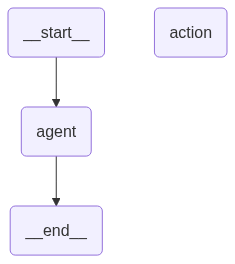

In [34]:
compiled_graph

In [38]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What did Colonel Hawkins say about the town of Amatol, NJ?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
            print(f"Tool used: {values['messages'][0].name}")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Ju7rBX4wEEn1Ja1xtwzmxJjm', 'function': {'arguments': '{"question":"What did Colonel Hawkins say about the town of Amatol, NJ?"}', 'name': 'historical_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 31, 'prompt_tokens': 129, 'total_tokens': 160, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_f12167b370', 'id': 'chatcmpl-C0wwsPcFW3uRLBtqnHZz2O2IsAlFl', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--acca28c2-a76c-4b9b-ba00-f3238c9a6ff6-0', tool_calls=[{'name': 'historical_rag_tool', 'args': {'question': 'What did Colonel Hawkins say about the town of Amatol, NJ?'}, 

In [39]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What was the motto of Amatol, NJ during construction?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        if node == "action":
            print(f"Tool used: {values['messages'][0].name}")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_BxJqL0e4e1K9oa3zK0FEDZKK', 'function': {'arguments': '{"question":"What was the motto of Amatol, NJ during construction?"}', 'name': 'historical_rag_tool'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 127, 'total_tokens': 156, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-nano-2025-04-14', 'system_fingerprint': 'fp_f12167b370', 'id': 'chatcmpl-C0wxzjr9ERrDITBwBqLIcRbadXA2o', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--cb49eef1-2e5a-4eb7-8d82-9a0035ad3156-0', tool_calls=[{'name': 'historical_rag_tool', 'args': {'question': 'What was the motto of Amatol, NJ during construction?'}, 'id': 'cal

In [42]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-mini", verbose=True))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [46]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(split_documents[:20], testset_size=3)

Applying CustomNodeFilter:   0%|          | 0/20 [00:00<?, ?it/s]       Node b0fd82e9-8f9e-49c0-83b1-ae8613f513e7 does not have a summary. Skipping filtering.
Node 2ad894e2-4e99-49d6-8998-909abb0f9e74 does not have a summary. Skipping filtering.
Node 54ef7d86-b721-4ad1-85ea-3015ea6bc051 does not have a summary. Skipping filtering.
Node f3c6c9a4-ac34-43b4-bbe1-bed7c62dc02c does not have a summary. Skipping filtering.
Node f81aa78f-c850-47b4-bfca-6c328c6e1e5a does not have a summary. Skipping filtering.
Node 41fad82f-de80-4505-bc56-4ec2dcf9d840 does not have a summary. Skipping filtering.
Node 4b42649f-a311-496e-957f-33f7048cbc87 does not have a summary. Skipping filtering.
Node 30de3437-473b-4159-b4d6-cc4ef2544480 does not have a summary. Skipping filtering.
Node 168b3c86-20c1-41c5-b9d0-98bebe74d5a4 does not have a summary. Skipping filtering.
Node 0f332c53-88cf-447a-b604-5e26b7ed305a does not have a summary. Skipping filtering.
Node 6157ac46-7ac5-4649-8e1f-f4bd8efce178 does not have a 

In [47]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,Can you provide detales on the budget preperat...,[Amatol Arsenal Prepares Budget \nSpecial to ...,According to a statement issued by Major C. E....,single_hop_specifc_query_synthesizer
1,How did the doubling of guards at Amatol Arsen...,[<1-hop>\n\nIn connection with the development...,Amatol Arsenal was held in a stand-by conditio...,multi_hop_abstract_query_synthesizer
2,How did the quick response to the brush fire m...,[<1-hop>\n\nARSENAL OUT OF DANGER FROM BUSH FI...,The quick and efficient work to extinguish the...,multi_hop_specific_query_synthesizer


In [111]:
import copy

dataset_baseline = copy.deepcopy(dataset)

In [112]:
import re
from langchain_core.messages.tool import ToolMessage
from langchain_core.messages.base import BaseMessage

def extract_page_contents_from_tool_msg(msg: BaseMessage) -> list[str]:
    """
    Safely extract page_content text blocks from a ToolMessage or other LangGraph message.

    Returns [] if:
    - The message is not a ToolMessage (e.g., Tavily or a direct response)
    - No page_content is found
    - Malformed or irrelevant content
    """
    if not isinstance(msg, ToolMessage):
        return []

    content = getattr(msg, 'content', '')
    if not content:
        return []

    pattern = r"page_content='(.*?)'"
    matches = re.findall(pattern, content, flags=re.DOTALL)
    return [m.strip() for m in matches if m.strip()]


In [113]:
for test_row in dataset_baseline:
    inputs = {"messages": [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = compiled_graph.invoke(inputs)

    # Model response (always last message)
    test_row.eval_sample.response = response["messages"][-1].content

    # Safely extract context from second-to-last message
    if len(response["messages"]) >= 2:
        tool_msg = response["messages"][-2]
        test_row.eval_sample.retrieved_contexts = extract_page_contents_from_tool_msg(tool_msg)
    else:
        test_row.eval_sample.retrieved_contexts = []


In [114]:
dataset_baseline.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Can you provide detales on the budget preperat...,[The Army’s Ordnance Department took over the ...,[Amatol Arsenal Prepares Budget \nSpecial to ...,"The Amatol Arsenal, which was initially opened...",According to a statement issued by Major C. E....,single_hop_specifc_query_synthesizer
1,How did the doubling of guards at Amatol Arsen...,[FEAR BOMB PLOT Amatol Munition Works Under He...,[<1-hop>\n\nIn connection with the development...,The doubling of guards at Amatol Arsenal was d...,Amatol Arsenal was held in a stand-by conditio...,multi_hop_abstract_query_synthesizer
2,How did the quick response to the brush fire m...,[Shell Loading to Continue Special to The Inqu...,[<1-hop>\n\nARSENAL OUT OF DANGER FROM BUSH FI...,The quick response to the brush fire menace ne...,The quick and efficient work to extinguish the...,multi_hop_specific_query_synthesizer


In [115]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset_baseline.to_pandas())

In [116]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))

In [117]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        ContextEntityRecall(), 
        # FactualCorrectness(),
        # ResponseRelevancy(),
        # NoiseSensitivity()
        ],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 9/9 [00:26<00:00,  2.92s/it]


{'context_recall': 0.8889, 'faithfulness': 0.8542, 'context_entity_recall': 0.3611}

In [144]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

def retrieve_adjusted(state):
  compressor = CohereRerank(model="rerank-v3.5", top_n=10)
  compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever)
  retrieved_docs = compression_retriever.invoke(state["question"])
  return {"context" : retrieved_docs}

In [145]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a historical assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

In [146]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4.1-nano")

In [147]:
def generate(state):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.format_messages(question=state["question"], context=docs_content)
    response = llm.invoke(messages)
    return {"response": response.content} 

In [148]:
from langgraph.graph import START, StateGraph
from typing_extensions import TypedDict
from langchain_core.documents import Document

class State(TypedDict):
    question: str
    context: list[Document]
    response: str

In [149]:
graph_builder = StateGraph(State).add_sequence([retrieve_adjusted, generate])
graph_builder.add_edge(START, "retrieve_adjusted")
graph = graph_builder.compile()

In [150]:
response = graph.invoke({"question": "What did Colonel Hawkins say about the town and plant of Amatol, NJ?"})
print(response["response"])

Colonel Hawkins said that the town of Amatol and its plant were difficult to staff initially because people were reluctant to go there due to the danger involved. To address this, they had to build attractive accommodations to persuade workers to stay. He noted that because of the inherent dangers, particularly after the plant at Morgan, N.J., exploded on October 4th, it was challenging to get and retain workers. Additionally, he mentioned that Amatol was situated between Atlantic City and Philadelphia, making it conveniently located, and it was built on a substantial safety zone of about 6,000 acres to protect the workers and the town from potential accidents at the plant.


In [151]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage

@tool
def historical_rag_tool(question: str) -> str:
	"""Useful for when you need to answer questions about history. Input should be a fully formed question."""
	response = graph.invoke({"question": question})
	return {
		"messages": [HumanMessage(content=response["response"])],
		"context": response["context"]
    }

In [152]:
tool_belt = [
    tavily_tool,
    historical_rag_tool
]

In [153]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

In [154]:
model = model.bind_tools(tool_belt)

In [155]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]
  context: list[Document]

In [156]:
from langgraph.prebuilt import ToolNode

def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    return {
        "messages": [response],
        "context": state.get("context", [])
    }

tool_node = ToolNode(tool_belt)

In [157]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

In [158]:
uncompiled_graph.set_entry_point("agent")


In [159]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

In [160]:
uncompiled_graph.add_edge("action", "agent")


In [161]:
compiled_graph_w_embeddings = uncompiled_graph.compile()


In [162]:
import copy

dataset_w_embeddings = copy.deepcopy(dataset)

In [163]:
for test_row in dataset_w_embeddings:
    inputs = {"messages": [HumanMessage(content=test_row.eval_sample.user_input)]}
    response = compiled_graph.invoke(inputs)

    # Model response (always last message)
    test_row.eval_sample.response = response["messages"][-1].content

    # Safely extract context from second-to-last message
    if len(response["messages"]) >= 2:
        tool_msg = response["messages"][-2]
        test_row.eval_sample.retrieved_contexts = extract_page_contents_from_tool_msg(tool_msg)
    else:
        test_row.eval_sample.retrieved_contexts = []


In [164]:
dataset_w_embeddings.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,synthesizer_name
0,Can you provide detales on the budget preperat...,[Amatol Arsenal Prepares Budget \nSpecial to ...,[Amatol Arsenal Prepares Budget \nSpecial to ...,"Based on the available information, here are t...",According to a statement issued by Major C. E....,single_hop_specifc_query_synthesizer
1,How did the doubling of guards at Amatol Arsen...,"[ATLANTIC CITY, N. J., Feb. 14.— The scare at ...",[<1-hop>\n\nIn connection with the development...,The doubling of guards at Amatol Arsenal was a...,Amatol Arsenal was held in a stand-by conditio...,multi_hop_abstract_query_synthesizer
2,How did the quick response to the brush fire m...,[Shell Loading to Continue Special to The Inqu...,[<1-hop>\n\nARSENAL OUT OF DANGER FROM BUSH FI...,The quick response to the brush fire near Hamm...,The quick and efficient work to extinguish the...,multi_hop_specific_query_synthesizer


In [165]:
from ragas import EvaluationDataset

evaluation_dataset = EvaluationDataset.from_pandas(dataset_w_embeddings.to_pandas())

In [166]:
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4.1-nano"))

In [167]:
from ragas.metrics import LLMContextRecall, Faithfulness, FactualCorrectness, ResponseRelevancy, ContextEntityRecall, NoiseSensitivity
from ragas import evaluate, RunConfig

custom_run_config = RunConfig(timeout=360)

result = evaluate(
    dataset=evaluation_dataset,
    metrics=[
        LLMContextRecall(),
        Faithfulness(),
        ContextEntityRecall(), 
        # FactualCorrectness(),
        # ResponseRelevancy(),
        # NoiseSensitivity()
        ],
    llm=evaluator_llm,
    run_config=custom_run_config
)
result

Evaluating: 100%|██████████| 9/9 [00:16<00:00,  1.87s/it]


{'context_recall': 0.7222, 'faithfulness': 0.7348, 'context_entity_recall': 0.5556}